<a href="https://colab.research.google.com/github/moch1996/MachineLearningProj/blob/master/assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#모듈
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.optim import lr_scheduler

In [34]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [35]:
print(device)

cuda:0


In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [37]:
#MNIST DATA
data_train = datasets.MNIST(root = 'MNIST_data',
                             download=True,
                             train=False,
                             transform=transform
                             )
data_test = datasets.MNIST(root = 'MNIST_data', 
                             train= True, 
                             download=True, 
                             transform= transform)

In [38]:
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())

the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


In [39]:
batch_size = 125
train_loader = torch.utils.data.DataLoader(dataset = data_train,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset = data_test,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          drop_last = True)
print('number of train batch : ',len(train_loader))
print('number of train batch : ',len(test_loader))

number of train batch :  80
number of train batch :  480


In [40]:
class classification(nn.Module):
    def __init__(self):
        super(classification,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),            
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )       
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [41]:
learning_rate = 0.001
num_epoch = 100

In [42]:
classifier = classification().to(device)
optimizer = torch.optim.Adam(classifier.parameters(),lr=learning_rate)
loss_func = nn.NLLLoss().to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min')

In [43]:
for i in range(1,10) :
  if i > 5 :
    print(i) 

6
7
8
9


In [44]:
training_L_history = []
training_A_history = []
testing_L_history = []
testing_A_history = []
for epoch in range(1,num_epoch+1) :
    classifier.train()
    training_loss = 0
    training_correct = 0
    for i,(data,target) in enumerate(train_loader) :
        
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        result = classifier(data)

        loss = F.nll_loss(result,target)
        training_loss += F.nll_loss(result,target, reduction = 'sum').item()

        prediction = result.max(dim=1, keepdim=True)[1]
        training_correct += prediction.eq(target.view_as(prediction)).sum().item()

        loss.backward()
        optimizer.step()
    scheduler.step(loss)
    training_loss /= len(train_loader.dataset)
    training_accuracy = 100 * training_correct / len(train_loader.dataset)
    training_L_history.append(training_loss)
    training_A_history.append(training_accuracy)
    

    classifier.eval()
    testing_loss = 0
    testing_correct = 0
    with torch.no_grad() :
      for data, target in test_loader :
        data,target = data.to(device), target.to(device)

        result2 = classifier(data)

        loss2 = F.nll_loss(result2, target)
        testing_loss += F.nll_loss(result2, target, reduction = 'sum').item()

        prediction2 = result2.max(1, keepdim=True)[1]
        testing_correct += prediction2.eq(target.view_as(prediction2)).sum().item()
    testing_loss /= len(test_loader.dataset)
    testing_accuracy = 100 * testing_correct / len(test_loader.dataset)
    testing_L_history.append(testing_loss)
    testing_A_history.append(testing_accuracy)
    if epoch > num_epoch-10 :
      print('Epoch: {}, Loss: {}, LR: {}'.format(epoch, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 91, Loss: 0.0007921239593997598, LR: 1.0000000000000004e-08
Epoch: 92, Loss: 0.0006405595922842622, LR: 1.0000000000000004e-08
Epoch: 93, Loss: 0.0005577638512477279, LR: 1.0000000000000004e-08
Epoch: 94, Loss: 0.0005630296072922647, LR: 1.0000000000000004e-08
Epoch: 95, Loss: 0.0005261683254502714, LR: 1.0000000000000004e-08
Epoch: 96, Loss: 0.0006027391063980758, LR: 1.0000000000000004e-08
Epoch: 97, Loss: 0.0006415650714188814, LR: 1.0000000000000004e-08
Epoch: 98, Loss: 0.000617783167399466, LR: 1.0000000000000004e-08
Epoch: 99, Loss: 0.0006051340606063604, LR: 1.0000000000000004e-08
Epoch: 100, Loss: 0.0005084473523311317, LR: 1.0000000000000004e-08


In [45]:
testing_A_history

[94.70833333333333,
 97.715,
 98.11333333333333,
 97.15,
 98.39333333333333,
 98.585,
 98.60666666666667,
 98.64833333333333,
 98.655,
 98.64833333333333,
 98.73333333333333,
 98.67,
 98.705,
 98.7,
 98.68666666666667,
 98.70666666666666,
 98.70166666666667,
 98.71333333333334,
 98.71833333333333,
 98.69833333333334,
 98.695,
 98.735,
 98.68666666666667,
 98.72333333333333,
 98.69833333333334,
 98.7,
 98.70666666666666,
 98.72666666666667,
 98.72166666666666,
 98.705,
 98.68666666666667,
 98.70833333333333,
 98.69666666666667,
 98.71,
 98.67,
 98.69166666666666,
 98.73333333333333,
 98.71333333333334,
 98.695,
 98.71666666666667,
 98.70666666666666,
 98.69333333333333,
 98.71333333333334,
 98.71166666666667,
 98.695,
 98.705,
 98.725,
 98.705,
 98.71166666666667,
 98.71333333333334,
 98.67666666666666,
 98.70333333333333,
 98.70333333333333,
 98.71166666666667,
 98.69833333333334,
 98.70833333333333,
 98.72333333333333,
 98.705,
 98.69,
 98.68833333333333,
 98.70333333333333,
 98.70333

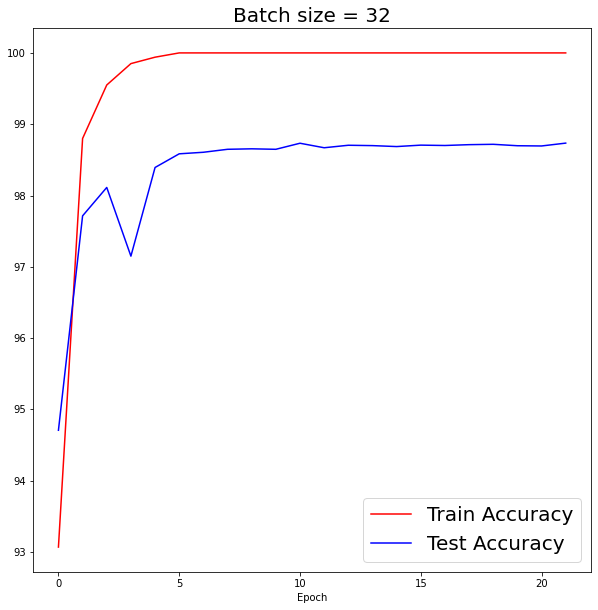

In [54]:
plt.figure(3, figsize=(10,10))
plt.plot(np.array(range(22)), training_A_history[0:22], c='r',label='Train Accuracy')
plt.plot(np.array(range(22)), testing_A_history[0:22], c='blue',label='Test Accuracy')
plt.xlabel('Epoch')
plt.title('Batch size = 32',fontsize = 20)
plt.legend(fontsize =20, loc='best')
plt.show()

In [49]:
print(np.argmax(testing_A_history),"        ",'%.5f'% np.max(testing_A_history))

21          98.73500


In [55]:
testing_A_history[0:22]

[94.70833333333333,
 97.715,
 98.11333333333333,
 97.15,
 98.39333333333333,
 98.585,
 98.60666666666667,
 98.64833333333333,
 98.655,
 98.64833333333333,
 98.73333333333333,
 98.67,
 98.705,
 98.7,
 98.68666666666667,
 98.70666666666666,
 98.70166666666667,
 98.71333333333334,
 98.71833333333333,
 98.69833333333334,
 98.695,
 98.735]

In [ ]:
print('%.10f' % num)


In [367]:
#찐
class classification(nn.Module):
    def __init__(self):
        super(classification,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),            
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )       
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [61]:
np.argmax(testing_A_history)+1

22

#OUTPUT

1.Plot the training and testing losses over epochs [2pt]

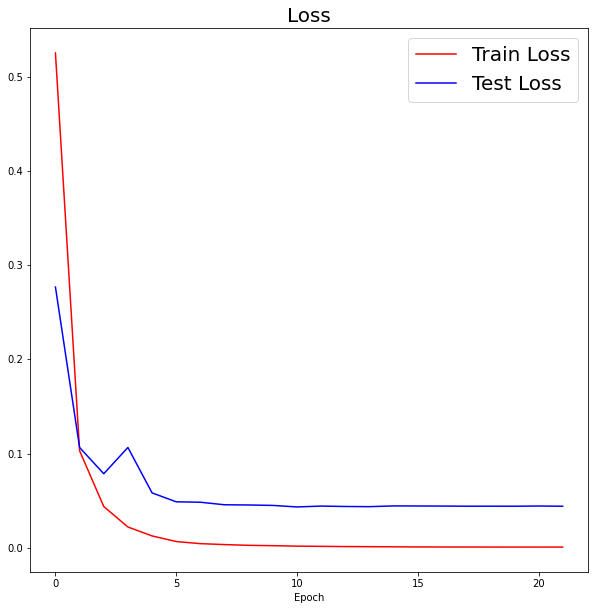

In [67]:
plt.figure(3, figsize=(10,10))
plt.plot(np.array(range(np.argmax(testing_A_history)+1)), training_L_history[0:np.argmax(testing_A_history)+1], c='red',label='Train Loss')
plt.plot(np.array(range(np.argmax(testing_A_history)+1)), testing_L_history[0:np.argmax(testing_A_history)+1], c='blue',label='Test Loss')
plt.xlabel('Epoch')
plt.title('Loss',fontsize = 20)
plt.legend(fontsize =20, loc='best')
plt.show()

2.Plot the training and testing accuracies over epochs [2pt]

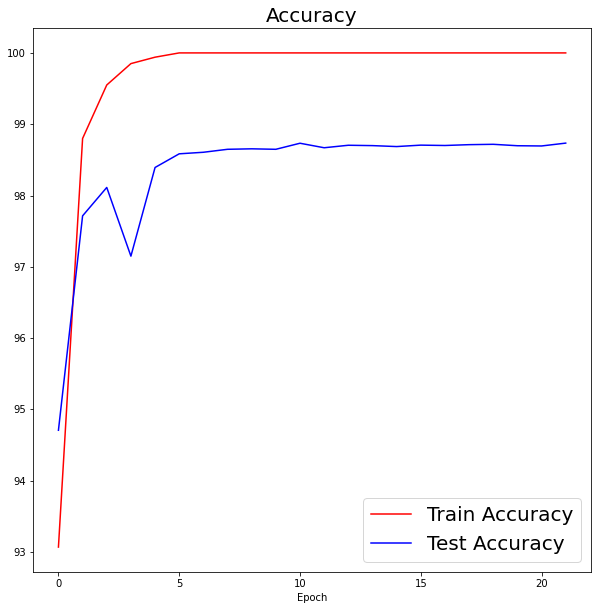

In [68]:
plt.figure(3, figsize=(10,10))
plt.plot(np.array(range(np.argmax(testing_A_history)+1)), training_A_history[0:np.argmax(testing_A_history)+1], c='red',label='Train Accuracy')
plt.plot(np.array(range(np.argmax(testing_A_history)+1)), testing_A_history[0:np.argmax(testing_A_history)+1], c='blue',label='Test Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy',fontsize = 20)
plt.legend(fontsize =20, loc='best')
plt.show()

3.Print the final training and testing losses at convergence [2pt]

In [93]:
print('Training Loss  = ','%.5f'%training_L_history[np.argmax(testing_A_history)])
print('Testing Loss  = ','%.5f'%testing_L_history[np.argmax(testing_A_history)])

Training Loss  =  0.00064
Testing Loss  =  0.04401


In [73]:
training_L_history[:20]

[0.5257441558837891,
 0.10299085536003112,
 0.04373492004871368,
 0.021955045104026794,
 0.012486192286014558,
 0.006515570837259292,
 0.004268331545591354,
 0.0032839889734983443,
 0.00247102370262146,
 0.002109330104291439,
 0.0016270822942256928,
 0.0014023286566138267,
 0.0011835743330419063,
 0.0010504266828298568,
 0.0009071693539619446,
 0.000771489205956459,
 0.0006989794194698334,
 0.0006695065621286631,
 0.0006438512802124023,
 0.0006385002586990595]

In [77]:
testing_A_history[0:22]

[94.70833333333333,
 97.715,
 98.11333333333333,
 97.15,
 98.39333333333333,
 98.585,
 98.60666666666667,
 98.64833333333333,
 98.655,
 98.64833333333333,
 98.73333333333333,
 98.67,
 98.705,
 98.7,
 98.68666666666667,
 98.70666666666666,
 98.70166666666667,
 98.71333333333334,
 98.71833333333333,
 98.69833333333334,
 98.695,
 98.735]

In [79]:
testing_A_history[np.argmax(testing_A_history)]

98.735

4.Print the final training and testing accuracies at convergence [20pt]

5.Print the testing accuracies within the last 10 epochs [5pt]